目的：OCT2Ageモデルを開発し、年齢予測に寄与するグリッドを可視化する

# Libraries

In [2]:
import numpy as np
from numpy import linalg as LA
import pandas as pd; pd.set_option('display.max_columns', None)

import scipy as sp
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
sns.set()
%precision 3

# utility
import sys
import time
import copy as cp
from tqdm import tqdm
from collections import defaultdict
import pickle
import openpyxl as px
import xlrd
from functools import reduce

# 乱数
rng = np.random.RandomState(1234)
random_state = 42

# ローカルライブラリ
%cd /users/keimy/git/OCT2Age
import src.archetypes as arch

/Users/keimy/git/OCT2Age


# Preprocess Data

In [3]:
from src.preprocess import make_datasets_in_2016

df_cpRNFL, OCT_cpRNFL = make_datasets_in_2016(filenames=["cpRNFL2016.csv"], ROI="cpRNFL")
df_mRNFL, OCT_mRNFL = make_datasets_in_2016(filenames=["mRNFL2016.csv"], ROI="mRNFL")
df_mGCLP, OCT_mGCLP = make_datasets_in_2016(filenames=["mGCLP2016.csv"], ROI="mGCLP")

dfs = [df_cpRNFL, df_mRNFL, df_mGCLP]
df = reduce(lambda left, right: pd.merge(left, right, on=["ID", "topID", "eye"]), dfs)

dfs_OCT = [OCT_cpRNFL, OCT_mRNFL, OCT_mGCLP]
df_OCT = reduce(lambda left, right: pd.merge(left, right, on=["ID", "topID", "eye"]), dfs_OCT)

df.shape, df_OCT.shape


((7666, 430), (7666, 215))

基本的にはkenshin dataとのマージデータ。AT,MSPのバージョンも

・df_merged

・df_merged_AT

・df_merged_MSP

・df_merged_AT_MSP


In [4]:
from src.preprocess import modify_kenshin_columns

# 健診データ
df_kenshin = pd.read_csv("./data_kenshin/2016R2.csv"); df_kenshin.drop(index=0, inplace=True)
# df_kenshin = pd.read_csv("../data_kenshin/h2016.csv")
df_kenshin = df_kenshin.rename(columns={"kenshinID": "ID" })
df_kenshin = df_kenshin.reset_index(drop=True)

# MSPデータ
df_msp = pd.read_csv("./data_kenshin/MSP.csv"); df_msp.drop(index=0, inplace=True)
df_msp = df_msp.rename(columns={"kenshinID": "ID" })
df_msp = df_msp.reset_index(drop=True)
df_msp.drop(columns=["sex","DOB","date"] ,inplace=True)

# ATデータ
df_merged_AT = pd.read_csv("./outputs/OCT_AT_kenshin_comb_K10.csv"); df_merged_AT.drop(index=0, inplace=True)
df_merged_AT = df_merged_AT.rename(columns={"kenshinID": "ID" })
df_merged_AT = df_merged_AT.reset_index(drop=True)


# 日付型のdate変数を作成
df_OCT['date'] = pd.to_datetime(df_OCT['topID'].astype(str).str[-8:])
df_kenshin['date'] = pd.to_datetime(df_kenshin['kenshindate'].astype(str))
# df_msp['date'] = pd.to_datetime(df_msp['date'].astype(str))


# IDを文字列型に変換
df_OCT['ID'] = df_OCT['ID'].astype(str)
df_kenshin['ID'] = df_kenshin['ID'].astype(str)
df_msp['ID'] = df_msp['ID'].astype(str)
df_merged_AT['ID'] = df_merged_AT['ID'].astype(str)

# IDとdateを使ってOCTとkenshinをマージ
df_merged = pd.merge(df_OCT, df_kenshin, on=['ID', 'date'], how='inner')

# MSPデータは年度を無視してマージ
df_merged_msp = pd.merge(df_merged, df_msp, on=['ID'], how='inner')
df_merged_msp_AT = pd.merge(df_merged_AT, df_msp, on=['ID'], how='inner')

# 健診データの加工
df_merged = modify_kenshin_columns(df_merged)
df_merged_msp = modify_kenshin_columns(df_merged_msp)
df_merged_AT = modify_kenshin_columns(df_merged_AT)
df_merged_msp_AT = modify_kenshin_columns(df_merged_msp_AT)

# MSPデータの加工
df_merged_msp["low_msp"] = (df_merged_msp.msp <= 12).astype(int)
df_merged_msp_AT["low_msp"] = (df_merged_msp_AT.msp <= 12).astype(int)


len(df_merged), len(df_merged_msp), len(df_merged_AT), len(df_merged_msp_AT)

/var/folders/2q/37wkg3rj6hb2r8hl9r779vgw0000gn/T/ipykernel_14077/1307241036.py:4: DtypeWarning: Columns (86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,106,110,111,112,113,114,115,116,117,118,119,120,121,122,123,125,126,127,130,133,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,187,188,189,190,191,192,193,194,199,200) have mixed types. Specify dtype option on import or set low_memory=False.
  df_kenshin = pd.read_csv("./data_kenshin/2016R2.csv"); df_kenshin.drop(index=0, inplace=True)
/var/folders/2q/37wkg3rj6hb2r8hl9r779vgw0000gn/T/ipykernel_14077/1307241036.py:16: DtypeWarning: Columns (536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,556,560,561,562,563,564,565,566,567,568,569,570,571,572,573,575,576,577,580,583,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,

(7662, 2556, 7661, 2556)

# Data Distribution in 2D

・年齢やMSPのアウトカムを　カットオフでバイナリーに

・OCTの領域別の検討



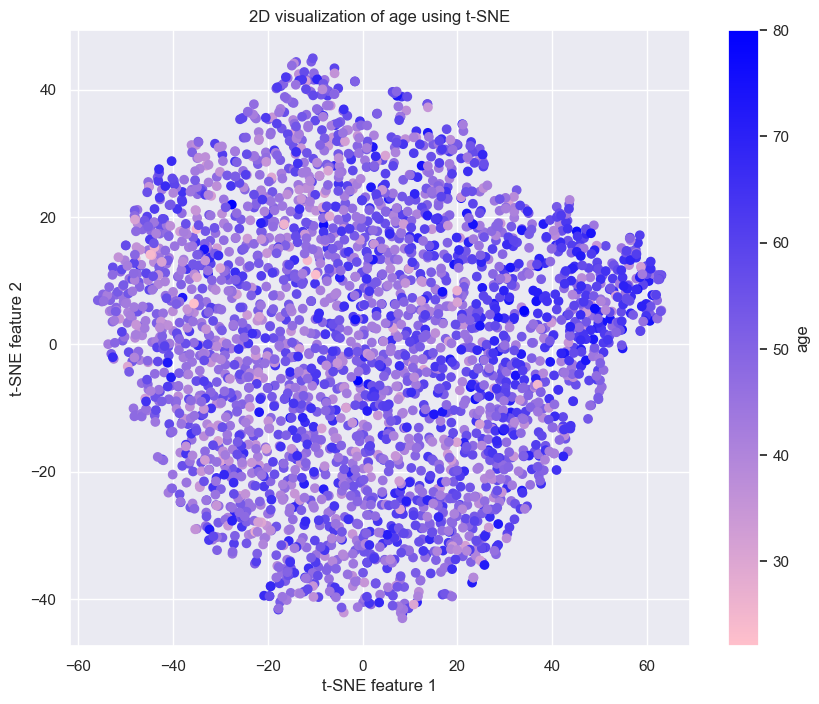

/Users/keimy/anaconda3/envs/torch/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


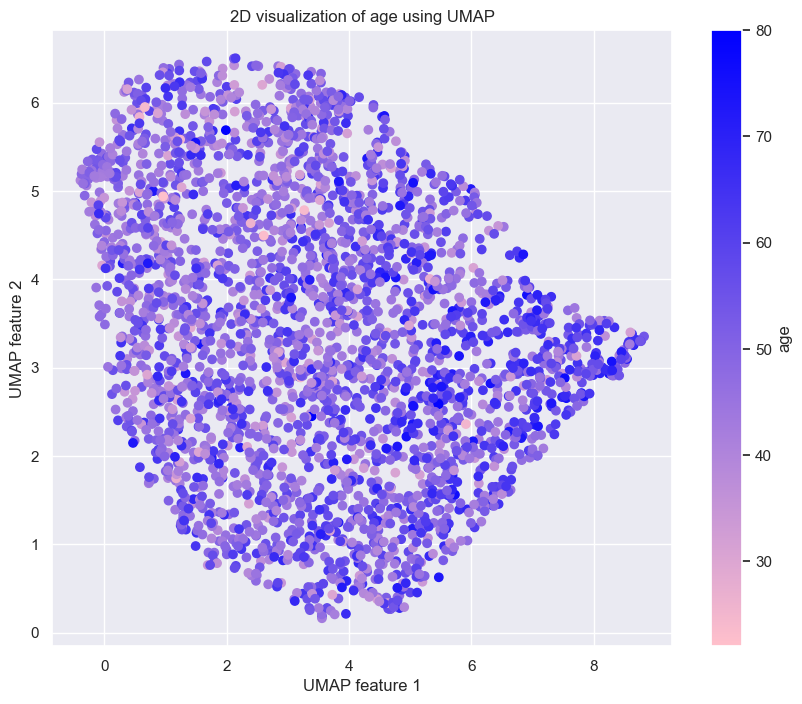

In [4]:
from src.preprocess import conversion_df2XY
from src.visualize import plot_TSNE, plot_UMAP

# アウトカム変数の加工
# 65歳以上が867/7662人
# MSP 13以下が189/2556人
df_merged["high_age"] = (df_merged.age >= 65).astype(int)
df_merged_AT["high_age"] = (df_merged_AT.age >= 65).astype(int)

df_merged_msp["low_msp"] = (df_merged_msp.msp <= 13).astype(int)
df_merged_msp_AT["low_msp"] = (df_merged_msp_AT.msp <= 13).astype(int)


# df_tmp = df_merged[:3000]
df_tmp = df_merged_AT[:3000]
# df_tmp = df_merged_msp[:]
# df_tmp = df_merged_msp_AT[:]


# アウトカムの欠損削除してからX,Yの作成
y_var = "age"
# df_tmp = df_tmp[df_tmp["HBA1C"] < 15]
df_tmp = df_tmp[df_tmp[y_var].notnull()]
X_df, y_df, AT_df = conversion_df2XY(df_tmp, y_var=y_var)

# 領域別
X_df_cpRNFL = X_df.iloc[:, :12]
X_df_mRNFL = X_df.iloc[:, 12:112]
X_df_mGCLP = X_df.iloc[:, 112:]

# X_df = X_df_mGCLP[:]

# 次元削減してプロット
plot_TSNE(X_df, y_df, var_name=y_var, random_state=42)
plot_UMAP(X_df, y_df, var_name=y_var, random_state=42)

# if AT_df is not None:
#     plot_TSNE(AT_df, y_df, var_name=y_var, random_state=42)
#     plot_UMAP(AT_df, y_df, var_name=y_var, random_state=42)



In [7]:
y_df

,age
0,61
1,68
2,42
3,52
4,74
...,...
2995,51
2996,49
2997,60
2998,49


In [5]:
# カテゴリーの場合に、単純な平均値の比較

X_df_1 = X_df.loc[y_df[y_df[y_var] == 1].index]

X_df_0 = X_df.loc[y_df[y_df[y_var] == 0].index]

X_df_1.values.mean(), X_df_0.values.mean(), len(X_df_1), len(X_df_0)

/var/folders/2q/37wkg3rj6hb2r8hl9r779vgw0000gn/T/ipykernel_13710/3808842527.py:7: RuntimeWarning: Mean of empty slice.
  X_df_1.values.mean(), X_df_0.values.mean(), len(X_df_1), len(X_df_0)
/Users/keimy/anaconda3/envs/torch/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(nan, nan, 0, 0)

# XGBoost

# MLP

In [ ]:
import importlib
import src.model.MLP

# モジュールの再読み込み
importlib.reload(src.model.MLP)

# モジュールから必要なクラスや関数をインポート
from src.model.MLP import MLP, train, valid

df_main : ４つのデータから使用するものを選ぶ

・df_merged

・df_merged_AT

・df_merged_MSP

・df_merged_AT_MSP

ハイパラ調整 : バッチサイズ、スケーラー

In [49]:
from src.preprocess import conversion_df2XY, create_scaled_dataloader_per_CV, create_AT_dataloader_per_CV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer


# アウトカムの欠損削除してからX,Yの作成
y_var = "age"
df_main = df_merged_AT.copy()
df_main = df_main[df_main[y_var].notnull()]
X_df, y_df, AT_df = conversion_df2XY(df_main, y_var=y_var)

# データローダーの作成
n_splits = 3
batch_size = 128

scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()
# scaler = FunctionTransformer()

X_train_CV, X_test_CV, X_scaler_CV, y_train_CV, y_test_CV, y_scaler_CV, train_loader_CV, test_loader_CV = create_scaled_dataloader_per_CV(X_df, y_df, scaler=scaler, n_splits=n_splits, batch_size=batch_size)

if AT_df is not None:
    AT_train_CV, AT_test_CV, AT_train_loader_CV, AT_test_loader_CV = create_AT_dataloader_per_CV(AT_df, n_splits=n_splits, batch_size=batch_size)

len(df_main), X_df.shape[1]

(7661, 212)

Epoch 1/20, Train Loss: 2.1001102298498155, Validation Loss: 1.2911994993686675
Epoch 2/20, Train Loss: 1.259519562125206, Validation Loss: 1.236368778347969
Epoch 3/20, Train Loss: 1.0667942762374878, Validation Loss: 1.2581728994846344
Epoch 4/20, Train Loss: 0.9774169102311134, Validation Loss: 1.247515869140625
Epoch 5/20, Train Loss: 0.9524797171354293, Validation Loss: 1.225925049185753
Epoch 6/20, Train Loss: 0.8789609551429749, Validation Loss: 1.2411382615566253
Epoch 7/20, Train Loss: 0.8529902309179306, Validation Loss: 1.2435326725244522
Epoch 8/20, Train Loss: 0.8404471531510354, Validation Loss: 1.2529650390148164
Epoch 9/20, Train Loss: 0.8092706248164176, Validation Loss: 1.2809132099151612
Epoch 10/20, Train Loss: 0.7974800229072571, Validation Loss: 1.2254032760858535
Epoch 11/20, Train Loss: 0.7679822847247124, Validation Loss: 1.2437427163124084
Epoch 12/20, Train Loss: 0.7540112167596817, Validation Loss: 1.2710858315229416
Epoch 13/20, Train Loss: 0.75284806787967

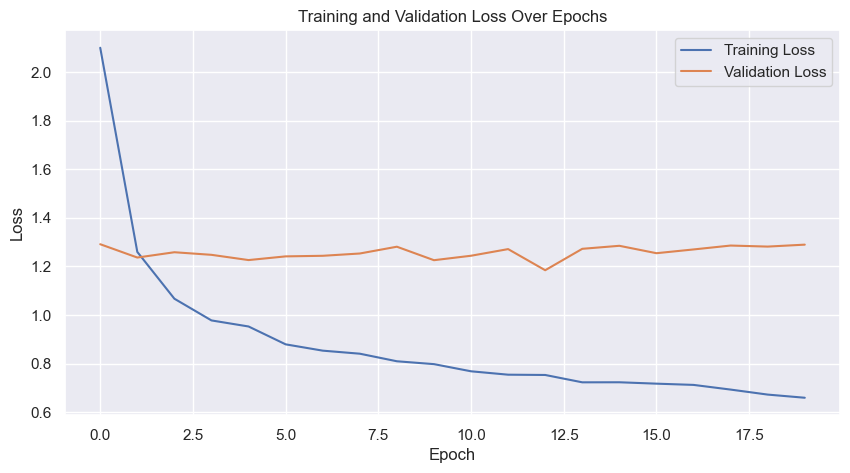

Epoch 1/20, Train Loss: 1.8909974843263626, Validation Loss: 1.189338219165802
Epoch 2/20, Train Loss: 1.1647088021039962, Validation Loss: 1.1748791664838791
Epoch 3/20, Train Loss: 1.0014231503009796, Validation Loss: 1.2208609700202941
Epoch 4/20, Train Loss: 0.9560721039772033, Validation Loss: 1.1990640342235566
Epoch 5/20, Train Loss: 1.0422333881258965, Validation Loss: 1.1035505294799806
Epoch 6/20, Train Loss: 0.8937319755554199, Validation Loss: 1.178310936689377
Epoch 7/20, Train Loss: 0.8807035863399506, Validation Loss: 1.1387795507907867
Epoch 8/20, Train Loss: 0.8357347995042801, Validation Loss: 1.145537257194519
Epoch 9/20, Train Loss: 0.8473931953310967, Validation Loss: 1.128287562727928
Epoch 10/20, Train Loss: 0.8378557652235031, Validation Loss: 1.1500582844018936
Epoch 11/20, Train Loss: 0.7947719722986222, Validation Loss: 1.1278237789869308
Epoch 12/20, Train Loss: 0.7742344185709953, Validation Loss: 1.169594231247902
Epoch 13/20, Train Loss: 0.75004673153162,

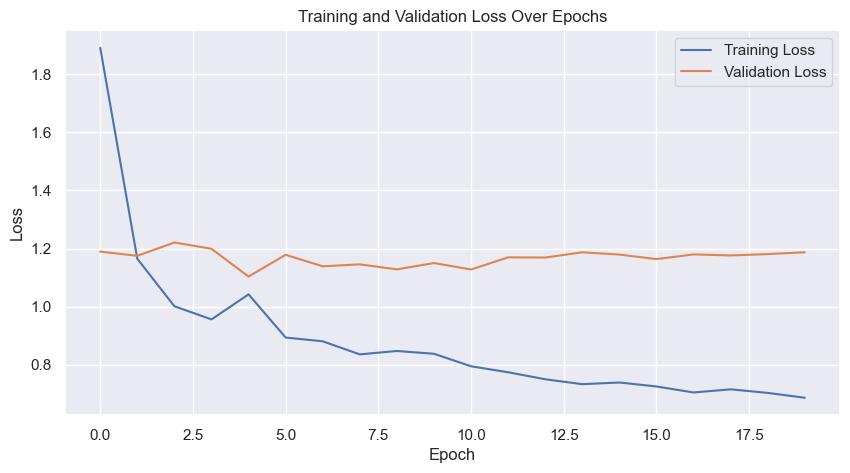

Epoch 1/20, Train Loss: 1.7431802660226823, Validation Loss: 1.3192010283470155
Epoch 2/20, Train Loss: 1.1735509797930717, Validation Loss: 1.178962630033493
Epoch 3/20, Train Loss: 1.0654100745916366, Validation Loss: 1.1296470642089844
Epoch 4/20, Train Loss: 0.9715571209788323, Validation Loss: 1.1570165127515792
Epoch 5/20, Train Loss: 0.9304972767829895, Validation Loss: 1.1699774086475372
Epoch 6/20, Train Loss: 0.890059994161129, Validation Loss: 1.1706715136766435
Epoch 7/20, Train Loss: 0.8609458297491074, Validation Loss: 1.1602386385202408
Epoch 8/20, Train Loss: 0.9144414708018302, Validation Loss: 1.168365553021431
Epoch 9/20, Train Loss: 0.8383987993001938, Validation Loss: 1.1658916383981706
Epoch 10/20, Train Loss: 0.8617093026638031, Validation Loss: 1.1428761601448059
Epoch 11/20, Train Loss: 0.8243384793400764, Validation Loss: 1.1529010891914369
Epoch 12/20, Train Loss: 0.7970856383442879, Validation Loss: 1.1938301652669907
Epoch 13/20, Train Loss: 0.7594004079699

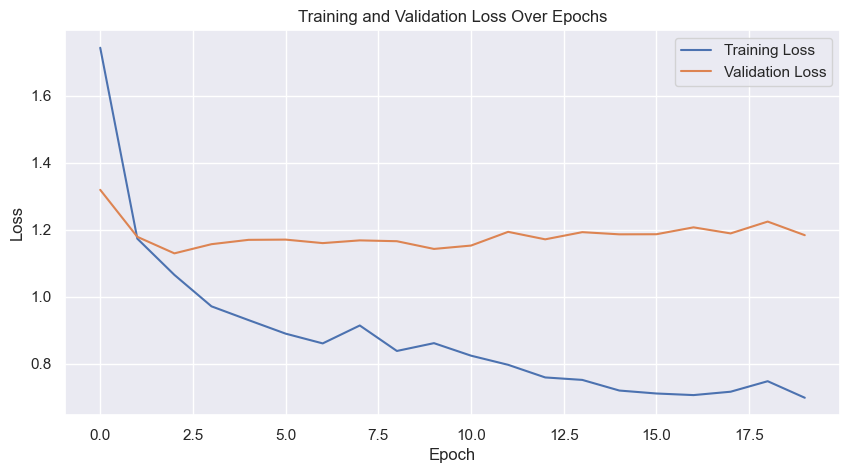

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from src.model.MLP import MLP, train, valid


# ハイパラ
epochs = 20
dropout_rate = 0.2
lr = 0.001

# モデルの設定
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = "cpu"


model_CV = []
for k in range(n_splits):
    model = MLP(input_dim=X_df.shape[1], hidden_dims=[128,128], output_dim=1, dropout_rate=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    # train and valid per epoch
    for epoch in range(epochs):
        # トレーニング
        train_loss = train(model, train_loader_CV[k], optimizer=optimizer, device=device, criterion=nn.MSELoss())
        train_losses.append(train_loss)

        # 検証
        val_loss = valid(model, test_loader_CV[k],device=device)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

    # save model per CV
    model_CV.append(model)

    # 損失のプロット
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



In [50]:

y_pred_from_test_CV = []
y_pred_from_train_CV = []


for k in range(n_splits):
    model = model_CV[k]
    model.eval()

    # X_test
    X_test = X_test_CV[k].to_numpy()
    X_scaler = X_scaler_CV[k]
    X_test_scaled = X_scaler.transform(X_test)
    X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)

    # X_train
    X_train = X_train_CV[k].to_numpy()
    X_scaler = X_scaler_CV[k]
    X_train_scaled = X_scaler.transform(X_train)
    X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32)

    y_pred_from_test = model(X_test_scaled)
    y_pred_from_test_CV.append(y_pred_from_test)

    y_pred_from_train = model(X_train_scaled)
    y_pred_from_train_CV.append(y_pred_from_train)

    
    # 予測結果を元に戻す
    # y_scaler = y_scaler_CV[k]
    # y_pred = y_scaler.inverse_transform(y_pred_from_test.detach().numpy())


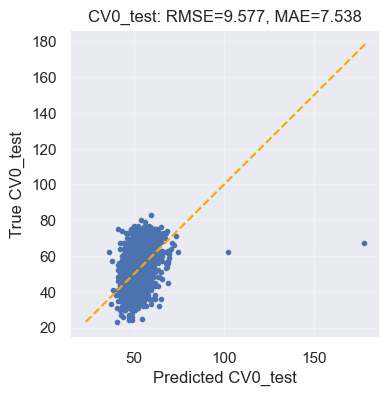

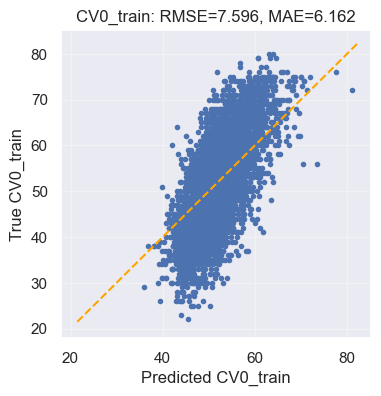

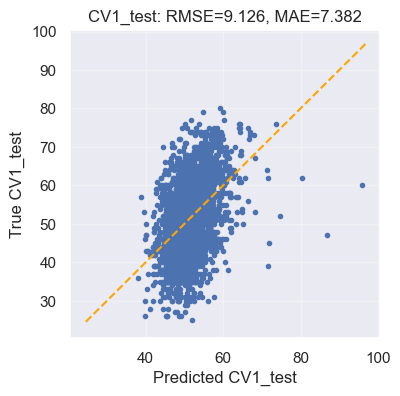

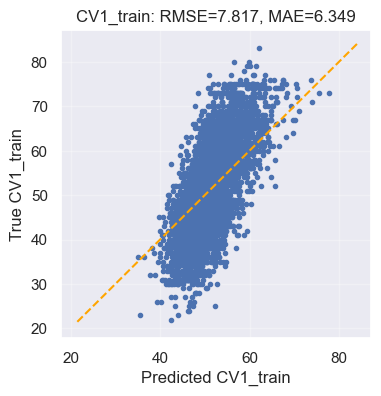

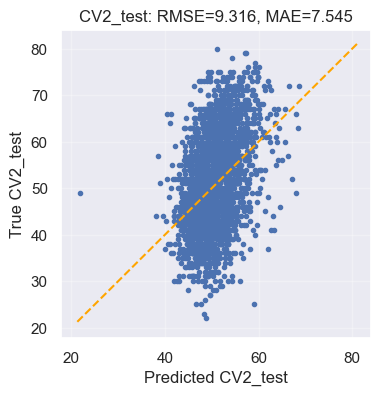

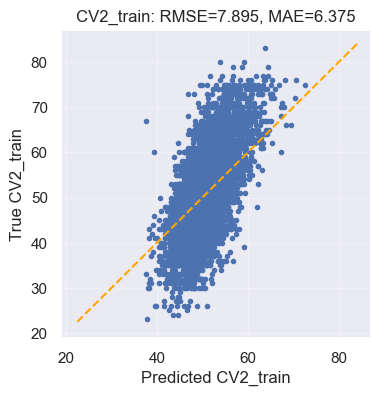

In [54]:
from src.eval_plot import calc_reg_metrics, plot_reg_metrics

for k in range(n_splits):
    y_scaler = y_scaler_CV[k]

    # y_testのスケーリング
    y_test = y_test_CV[k].to_numpy()
    y_test_scaled = y_scaler.transform(y_test)

    # y_trainのスケーリング
    y_train = y_train_CV[k].to_numpy()
    y_train_scaled = y_scaler.transform(y_train)

    # スケーリングされた予測値
    y_pred_from_test = y_pred_from_test_CV[k].detach().numpy()
    y_pred_from_train = y_pred_from_train_CV[k].detach().numpy()

    # plot figures
    plot_reg_metrics(y_test_scaled, y_pred_from_test, y_scaler_CV[k], target_name=f"CV{k}_test")
    plot_reg_metrics(y_train_scaled, y_pred_from_train, y_scaler_CV[k], target_name=f"CV{k}_train")

アーキタイプとの関連も検討

In [ ]:
AT_test_CV[0].shape, y_test_CV[0].shape, y_pred_CV[0].shape

# CNN

df_main : ４つのデータから使用するものを選ぶ

・df_merged

・df_merged_AT

・df_merged_MSP

・df_merged_AT_MSP

ハイパラ調整 : バッチサイズ、スケーラー

In [5]:
from src.preprocess import conversion_df2XY, create_CNN_dataloader_per_CV, create_AT_dataloader_per_CV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer


# アウトカムの欠損削除してからX,Yの作成
y_var = "age"
df_main = df_merged_AT.copy()
df_main = df_main[df_main[y_var].notnull()]
X_df, y_df, AT_df = conversion_df2XY(df_main, y_var=y_var)

# データローダーの作成
n_splits = 3
batch_size = 64

# scaler = StandardScaler()
# scaler = MinMaxScaler()
scaler = RobustScaler()
# scaler = FunctionTransformer()


# CNN専用のデータローダー
_, X_test_CV, _, y_test_CV, y_scaler_CV, train_loader_CV, test_loader_CV  = create_CNN_dataloader_per_CV(X_df, y_df, scaler=scaler, n_splits=n_splits, batch_size=batch_size)

if AT_df is not None:
    AT_train_CV, AT_test_CV, AT_train_loader_CV, AT_test_loader_CV = create_AT_dataloader_per_CV(AT_df, n_splits=n_splits, batch_size=batch_size)

len(df_main), X_df.shape[1]

(7661, 212)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from src.model.MLP import MLP, train, valid


# ハイパラ
epochs = 20
dropout_rate = 0.2
lr = 0.001

# モデルの設定
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = "cpu"


model_CV = []
for k in range(n_splits):
    model = MLP(input_dim=X_df.shape[1], hidden_dims=[64,64], output_dim=1, dropout_rate=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    # train and valid per epoch
    for epoch in range(epochs):
        # トレーニング
        train_loss = train(model, train_loader_CV[k], optimizer=optimizer, device=device, criterion=nn.MSELoss())
        train_losses.append(train_loss)

        # 検証
        val_loss = valid(model, test_loader_CV[k],device=device)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

    # save model per CV
    model_CV.append(model)

    # 損失のプロット
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



# MLP_BCE

In [ ]:
import importlib
import src.model.MLP

# モジュールの再読み込み
importlib.reload(src.model.MLP)

# モジュールから必要なクラスや関数をインポート
from src.model.MLP import MLP, train, valid

df_main : ４つのデータから使用するものを選ぶ

・df_merged

・df_merged_AT

・df_merged_MSP

・df_merged_AT_MSP

ハイパラ調整 : バッチサイズ、スケーラー

In [29]:
from src.preprocess import conversion_df2XY, create_scaled_dataloader_per_CV, create_AT_dataloader_per_CV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer

# カテゴリカル変数の加工
# 65歳以上が867/7662人
# MSP 13以下が189/2556人
df_merged["high_age"] = (df_merged.age >= 65).astype(int)
df_merged_AT["high_age"] = (df_merged_AT.age >= 65).astype(int)

df_merged_msp["low_msp"] = (df_merged_msp.msp <= 13).astype(int)
df_merged_msp_AT["low_msp"] = (df_merged_msp_AT.msp <= 13).astype(int)


# アウトカムの欠損削除してからX,Yの作成
y_var = "high_age"
df_main = df_merged.copy()
df_main = df_main[df_main[y_var].notnull()]
X_df, y_df, AT_df = conversion_df2XY(df_main, y_var=y_var)

# データローダーの作成
n_splits = 3
batch_size = 64

# scaler = StandardScaler()
scaler = MinMaxScaler()
# scaler = RobustScaler()
# scaler = FunctionTransformer()

_, X_test_CV, X_scaler_CV, _, y_test_CV, y_scaler_CV, train_loader_CV, test_loader_CV = create_scaled_dataloader_per_CV(X_df, y_df, scaler=scaler, n_splits=n_splits, batch_size=batch_size)

if AT_df is not None:
    AT_train_CV, AT_test_CV, AT_train_loader_CV, AT_test_loader_CV = create_AT_dataloader_per_CV(AT_df, n_splits=n_splits, batch_size=batch_size)

len(df_main), X_df.shape[1]

(7662, 212)

Epoch 1/10, Train Loss: 0.37709340937435626, Validation Loss: 0.33862491212785245
Epoch 2/10, Train Loss: 0.3556711344048381, Validation Loss: 0.3376610193401575
Epoch 3/10, Train Loss: 0.3594182973727584, Validation Loss: 0.33626612797379496
Epoch 4/10, Train Loss: 0.35450365133583545, Validation Loss: 0.34231727123260497
Epoch 5/10, Train Loss: 0.3511975074186921, Validation Loss: 0.33727071471512315
Epoch 6/10, Train Loss: 0.355229870416224, Validation Loss: 0.3405967626720667
Epoch 7/10, Train Loss: 0.34492717739194634, Validation Loss: 0.32868456579744815
Epoch 8/10, Train Loss: 0.33622522708028557, Validation Loss: 0.3312824277207255
Epoch 9/10, Train Loss: 0.3413963973522186, Validation Loss: 0.31791760995984075
Epoch 10/10, Train Loss: 0.3373593769967556, Validation Loss: 0.3352887578308582


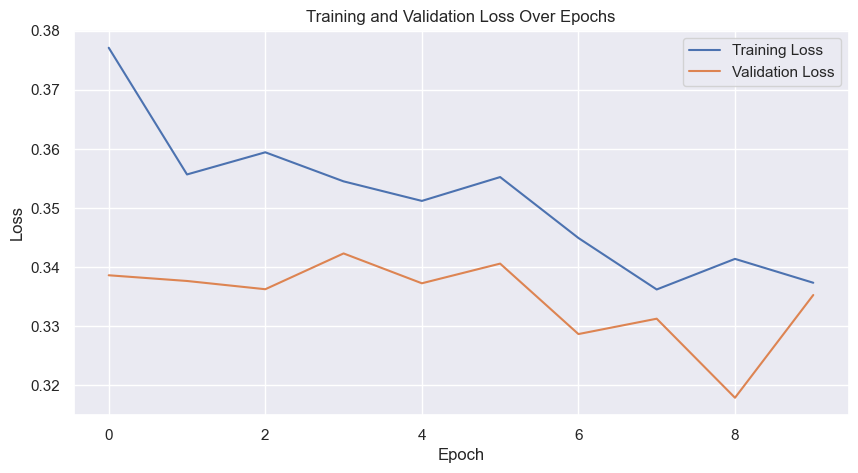

Epoch 1/10, Train Loss: 0.40059418361634014, Validation Loss: 0.34841879084706306
Epoch 2/10, Train Loss: 0.36427133828401564, Validation Loss: 0.3394575841724873
Epoch 3/10, Train Loss: 0.3594447152689099, Validation Loss: 0.33762622624635696
Epoch 4/10, Train Loss: 0.34996603690087796, Validation Loss: 0.3306234449148178
Epoch 5/10, Train Loss: 0.34726623706519605, Validation Loss: 0.32983468994498255
Epoch 6/10, Train Loss: 0.3477671993896365, Validation Loss: 0.3305132374167442
Epoch 7/10, Train Loss: 0.35007944647222755, Validation Loss: 0.3236776664853096
Epoch 8/10, Train Loss: 0.34084996543824675, Validation Loss: 0.32669216468930246
Epoch 9/10, Train Loss: 0.33398424573242663, Validation Loss: 0.3265641495585442
Epoch 10/10, Train Loss: 0.33175411047413944, Validation Loss: 0.3163731563836336


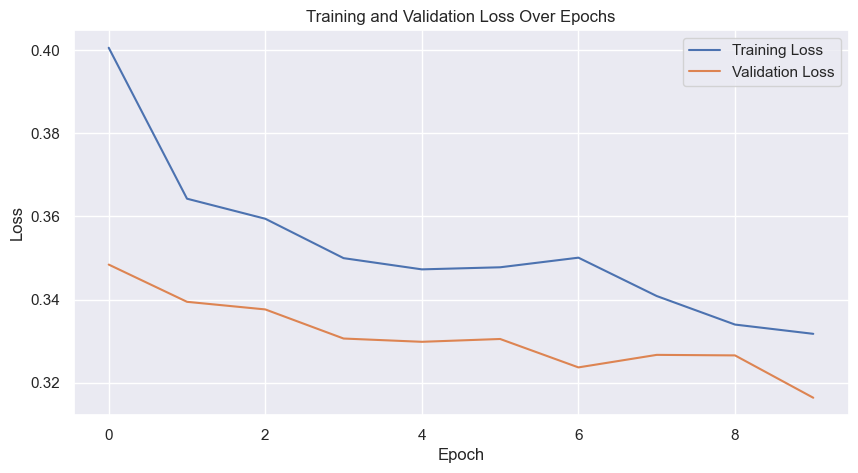

Epoch 1/10, Train Loss: 0.3757982451468706, Validation Loss: 0.3599227026104927
Epoch 2/10, Train Loss: 0.3572342490777373, Validation Loss: 0.35318170562386514
Epoch 3/10, Train Loss: 0.3492928817868233, Validation Loss: 0.34356806725263594
Epoch 4/10, Train Loss: 0.35256994850933554, Validation Loss: 0.34991708509624003
Epoch 5/10, Train Loss: 0.3503898695111275, Validation Loss: 0.3397224862128496
Epoch 6/10, Train Loss: 0.34304595850408076, Validation Loss: 0.33646940179169177
Epoch 7/10, Train Loss: 0.34140764083713293, Validation Loss: 0.33937573842704294
Epoch 8/10, Train Loss: 0.33745410218834876, Validation Loss: 0.3285432066768408
Epoch 9/10, Train Loss: 0.3301251754164696, Validation Loss: 0.3311151903122663
Epoch 10/10, Train Loss: 0.3372479841113091, Validation Loss: 0.32864882349967955


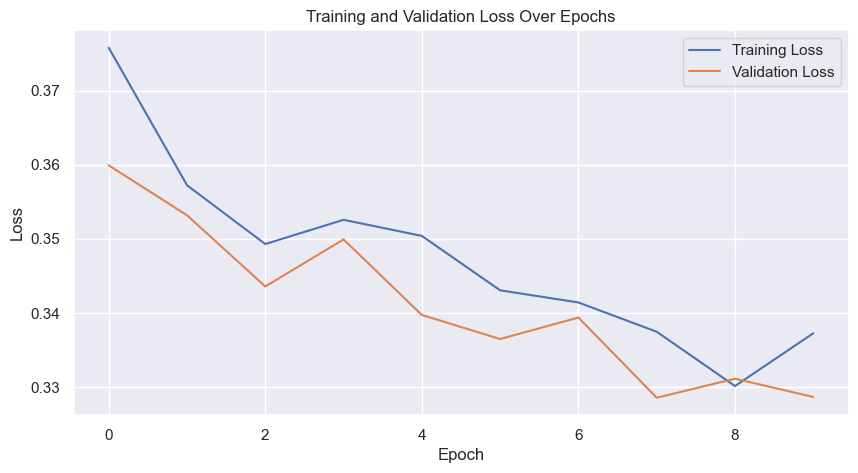

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from src.model.MLP import MLP_binary, train, valid


# ハイパラ
epochs = 10
dropout_rate = 0.2
lr = 0.001

# モデルの設定
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = "cpu"



model_CV = []
for k in range(n_splits):
    model = MLP_binary(input_dim=X_df.shape[1], hidden_dims=[128,64,32], output_dim=1, dropout_rate=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    # train and valid per epoch
    for epoch in range(epochs):
        # トレーニング
        train_loss = train(model, train_loader_CV[k], optimizer=optimizer, device=device, criterion=nn.BCELoss())
        train_losses.append(train_loss)

        # 検証
        val_loss = valid(model, test_loader_CV[k],device=device, criterion=nn.BCELoss())
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

    # save model per CV
    model_CV.append(model)

    # 損失のプロット
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



In [31]:

y_pred_scaled_CV = []
y_pred_CV = []

for k in range(n_splits):
    X_test = X_test_CV[k].to_numpy()

    # X_testにスケーラーを適用
    X_scaler = X_scaler_CV[k]
    X_test_scaled = X_scaler.transform(X_test)
    X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)

    # テストデータの予測
    model = model_CV[k]
    model.eval()

    y_pred_scaled = model(X_test_scaled)
    y_pred_scaled_CV.append(y_pred_scaled)

    # 予測結果を元に戻す
    y_scaler = y_scaler_CV[k]
    y_pred = y_scaler.inverse_transform(y_pred_scaled.detach().numpy())
    y_pred_CV.append(y_pred)


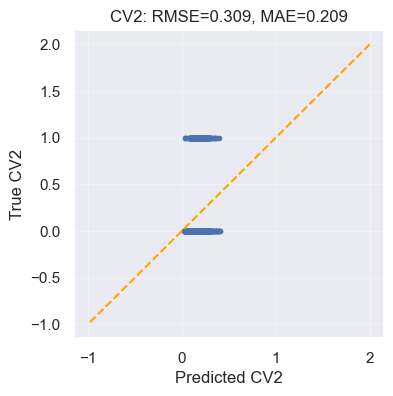

In [34]:
from src.eval_plot import calc_reg_metrics, plot_reg_metrics


k = 2

y_test = y_test_CV[k].to_numpy()
y_scaler = y_scaler_CV[k]
y_test_scaled = y_scaler.transform(y_test)

y_pred_scaled = y_pred_scaled_CV[k].detach().numpy()

calc_reg_metrics(y_test_scaled, y_pred_scaled, y_scaler_CV[k])

plot_reg_metrics(y_test_scaled, y_pred_scaled, y_scaler_CV[k], target_name=f"CV{k}")